<a href="https://colab.research.google.com/github/analystanand/Machine-Learning/blob/master/Card_Transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capital One Data Science Challenge

### Dowload and Extract Data

In [0]:
# !git clone https://github.com/CapitalOneRecruiting/DS.git
# !unzip DS/transactions.zip

##Library Installations

In [154]:
# !pip install jsonlines
# !pip install pandas
# !pip install category_encoders
# !pip install -U imbalanced-learn
# !pip install scikit-plot
!pip install yellowbrick

In [155]:
%matplotlib inline
import numpy as np
import plotly.express as px
import pandas as pd
import seaborn as sns
import jsonlines
import matplotlib
from sklearn.pipeline import Pipeline,make_pipeline
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import scikitplot as skplt
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.model_selection import LearningCurve
from sklearn.svm import SVC
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report,plot_roc_curve
import category_encoders as ce
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.



#Question 1: Load

Read transactions from file and Load into panda dataFrame

In [0]:
FILENAME= "./transactions.txt"
transactions = []
with jsonlines.open(FILENAME) as file:
    transactions = [record for record in file]
transactions_df = pd.DataFrame(transactions)

In [157]:
print("Number of transaction records",transactions_df.shape[0])
print("No. of Customers",transactions_df.customerId.unique().shape[0])

Number of transaction records 786363
No. of Customers 5000


In [158]:
transactions_df.head(5)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.0,,,,True,,,False,False


### There are few empty columns and are not useful for analysis  and it good to drop them.

In [159]:
empty_columns = []
for i in transactions_df.columns.values:
  if len(set(transactions_df[i]))==1:
     empty_columns.append(i)

transactions_df = transactions_df.drop(empty_columns,axis=1)
transactions_df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False


In [0]:
transactions_df['transaction_id'] = transactions_df.index #for uniquely identifying record

In [161]:
transactions_df.dtypes

accountNumber                object
customerId                   object
creditLimit                 float64
availableMoney              float64
transactionDateTime          object
transactionAmount           float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                 object
posConditionCode             object
merchantCategoryCode         object
currentExpDate               object
accountOpenDate              object
dateOfLastAddressChange      object
cardCVV                      object
enteredCVV                   object
cardLast4Digits              object
transactionType              object
currentBalance              float64
cardPresent                    bool
expirationDateKeyInMatch       bool
isFraud                        bool
transaction_id                int64
dtype: object

In [162]:
transactions_df.describe()

,creditLimit,availableMoney,transactionAmount,currentBalance,transaction_id
count,786363.000000,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,4508.739089,393181.000000
std,11636.174890,8880.783989,147.725569,6457.442068,227003.589202
min,250.000000,-1005.630000,0.000000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,689.910000,196590.500000
50%,7500.000000,3184.860000,87.900000,2451.760000,393181.000000
75%,15000.000000,7500.000000,191.480000,5291.095000,589771.500000
max,50000.000000,50000.000000,2011.540000,47498.810000,786362.000000


#Question 2: Plot

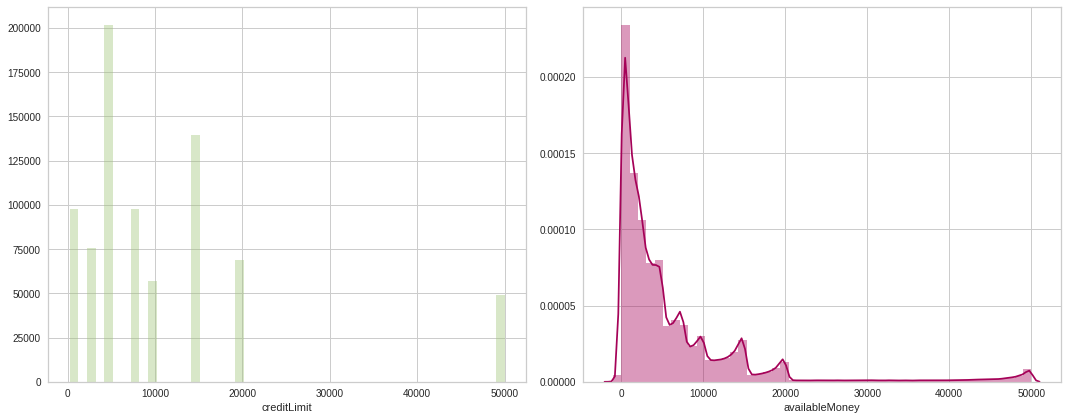

In [163]:
#reference:https://seaborn.pydata.org/examples/distplot_options.html
# Set up the matplotlib figure
f, axes = plt.subplots(1,2, figsize=(15, 6), sharex=False)
sns.distplot(transactions_df['creditLimit'],kde=False, color="g", ax=axes[0])
sns.distplot(transactions_df['availableMoney'],kde=True,color="m", ax=axes[1])
plt.tight_layout()
plt.show()

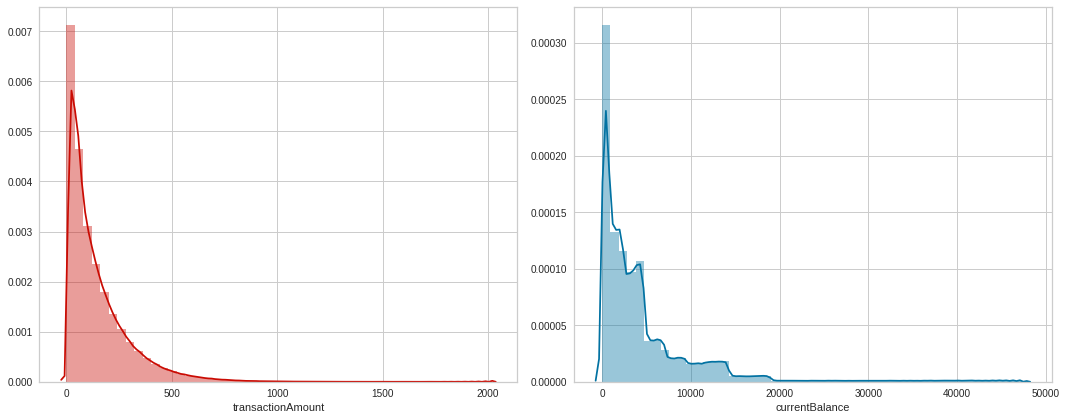

In [164]:
#reference:https://seaborn.pydata.org/examples/distplot_options.html
f, axes = plt.subplots(1,2, figsize=(15, 6), sharex=False)
sns.distplot(transactions_df['transactionAmount'],kde=True,norm_hist=True, color="r", ax=axes[0])
sns.distplot(transactions_df['currentBalance'],kde=True,norm_hist=True,color="b", ax=axes[1])
plt.tight_layout()
plt.show()

#Question 3: Data Wrangling - Duplicate Transactions

In [0]:
transaction_with_dup_flag = transactions_df[["customerId","transactionAmount","merchantName"]].duplicated()

In [0]:
transactions_df["isDuplicate"]=transaction_with_dup_flag

In [0]:
duplicate_transactions = transactions_df[transactions_df["isDuplicate"]==True]

In [0]:
result =  duplicate_transactions[["customerId","transactionAmount","merchantName","transactionDateTime"]].groupby(by=["customerId","transactionAmount","merchantName"]).count()

In [0]:
dup_analysis_df = result.reset_index()

In [0]:
dup_analysis_df = dup_analysis_df.rename(columns={"transactionDateTime": "occurence"})

In [0]:
dup_analysis_df['dup_category'] = np.where(dup_analysis_df['occurence']>1, 'multi-swipe', 'reversed')

In [172]:
analysis = dup_analysis_df.groupby(by=["dup_category"]).sum()
analysis.head()

,transactionAmount,occurence
dup_category,,
multi-swipe,272232.43,47451
reversed,3674589.58,27696


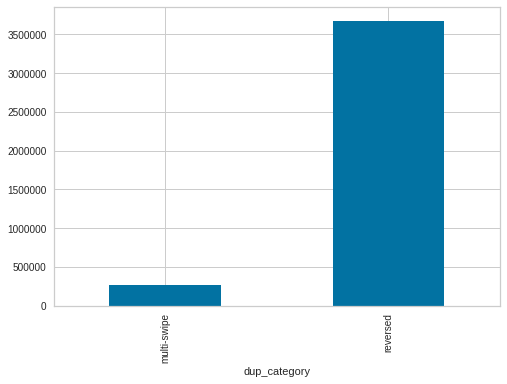

In [173]:
analysis["transactionAmount"].plot.bar()
plt.show()

# Question 4: Model

## Distribution of Fraud and Regular Case

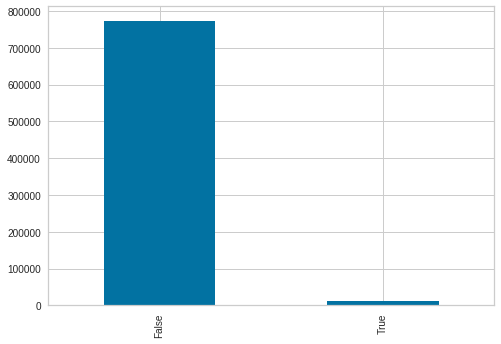

In [174]:
class_dist=pd.value_counts(transactions_df["isFraud"], sort= True)
class_dist.plot(kind= 'bar')
plt.show()

In [175]:
def class_percentage(t_df):
  No_of_Normal_transacation = len(t_df[t_df["isFraud"]==True]) 
  No_of_Fraud_transacation =len(t_df[t_df["isFraud"]==False])
  percent_of_fraud_transaction =  No_of_Fraud_transacation/(No_of_Normal_transacation+No_of_Fraud_transacation)
  percent_of_normal_transaction = No_of_Normal_transacation/(No_of_Normal_transacation+No_of_Fraud_transacation)
  print("percent of Normal transactions: {0:.2%}".format(percent_of_fraud_transaction))
  print("percent of Fraud transactions: {0:.2%}".format(percent_of_normal_transaction))

class_percentage(transactions_df)

percent of Normal transactions: 98.42%
percent of Fraud transactions: 1.58%


As we can see that fraud transactions are just 1.58% of total transactions. This is highly imbalanced dataset so we have to carefully choose metric for performance evaluation as well as train a model which is not baised towards normal transaction.For example: randomly predicting all transaction as normal will provide high accuracy to the model but it's not useful for us. 


---
There are popular three techniques to handle imbalanced data.
1. undersampling the majority class
2. oversampling the minority class
3. Weight based loss function to penalize model when it observe minority class

We will try only undersampling method although we will lose information but to train a model without an inherent bias towards majority class.

First of all lets seperate the data into training and test set before undersampling this is real scenarios we will be facing when it comes to deployment.

In [0]:
transactions_df["transactionDateTime"] = pd.to_datetime(transactions_df["transactionDateTime"])

In [0]:
transactions_df["dateOfLastAddressChange"] = pd.to_datetime(transactions_df["dateOfLastAddressChange"])
transactions_df['diff_address_transactions'] = transactions_df['transactionDateTime'] - transactions_df['dateOfLastAddressChange']
transactions_df['diff_address_transactions'] = transactions_df['diff_address_transactions']/np.timedelta64(1,'D')

In [0]:
transactions_df["accountOpenDate"] = pd.to_datetime(transactions_df["accountOpenDate"])
transactions_df['diff_accountopen_transactions'] = transactions_df['transactionDateTime'] - transactions_df['accountOpenDate']
transactions_df['diff_accountopen_transactions'] = transactions_df['diff_accountopen_transactions']/np.timedelta64(1,'D')

In [0]:
transactions_df["currentExpDate"] = pd.to_datetime(transactions_df["currentExpDate"],infer_datetime_format=True)
transactions_df['diff_currentExpDate_transactions'] =  transactions_df['currentExpDate'] - transactions_df['transactionDateTime'] 
transactions_df['diff_currentExpDate_transactions'] = transactions_df['diff_currentExpDate_transactions']/np.timedelta64(1,'D')


In [180]:
transactions_df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transaction_id,isDuplicate,diff_address_transactions,diff_accountopen_transactions,diff_currentExpDate_transactions
0,737265056,737265056,5000.0,5000.0,2016-08-13 14:27:32,98.55,Uber,US,US,02,01,rideshare,2023-06-01,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False,0,False,518.602454,518.602454,2482.397546
1,737265056,737265056,5000.0,5000.0,2016-10-11 05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,2024-02-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False,1,False,577.212431,577.212431,2668.787569
2,737265056,737265056,5000.0,5000.0,2016-11-08 09:18:39,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False,2,False,605.387951,605.387951,3187.612049
3,737265056,737265056,5000.0,5000.0,2016-12-10 02:14:50,7.47,Play Store,US,US,09,01,mobileapps,2025-08-01,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False,3,True,637.093634,637.093634,3155.906366
4,830329091,830329091,5000.0,5000.0,2016-03-24 21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,2029-10-01,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False,4,False,231.878310,231.878310,4938.121690


Dropping features which don't need to be fed into in baseline model or we have already derived features from those: 

1. accountNumber,
2. customerId,
3. transactionDateTime,
4. currentExpDate,
5. accountOpenDate
6. dateOfLastAddressChange
7. cardCVV	
8. enteredCVV	
9. cardLast4Digits

In [0]:
transactions_df = transactions_df.drop(["accountNumber","customerId","transactionDateTime","currentExpDate","accountOpenDate","dateOfLastAddressChange","cardCVV","enteredCVV","cardLast4Digits",],axis=1)

In [0]:
X_data = transactions_df.drop('isFraud', axis=1)
y_label = transactions_df['isFraud']

In [183]:
le = LabelEncoder()
label_encoder = le.fit(y_label)
y_label = label_encoder.transform(y_label)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, test_size=0.2,stratify=y_label)

print("Training Size:",X_train.shape,"Testing Size:",X_test.shape)

Training Size: (629090, 18) Testing Size: (157273, 18)


In [0]:
train_df = X_train.copy()
train_df["isFraud"] = pd.Series(le.inverse_transform(y_train))

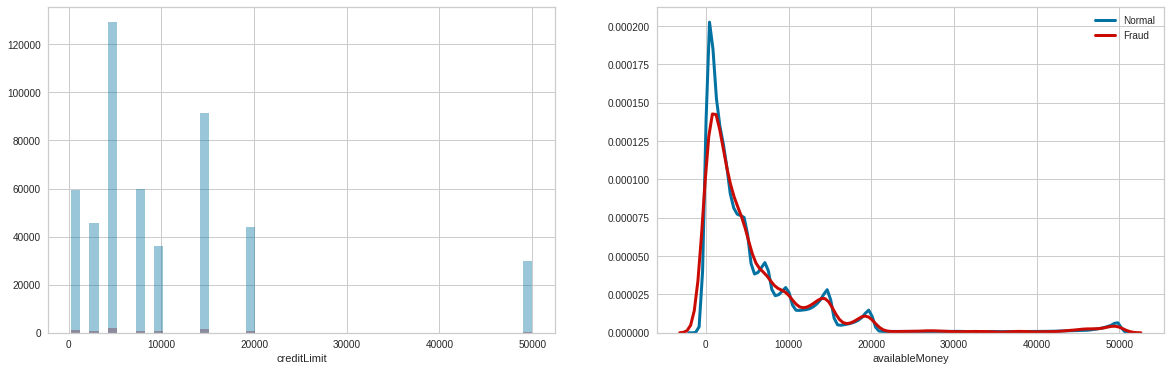

In [185]:
f, axes = plt.subplots(1,2, figsize=(20, 6), sharex=False)
sns.distplot(train_df[train_df['isFraud']==True]["creditLimit"],hist=True,kde=False,color="r",label='Fraud',ax=axes[0])
sns.distplot(train_df[train_df['isFraud']==False]['creditLimit'],hist=True,kde=False,color="b",label='Normal',ax=axes[0])
sns.distplot(train_df[train_df['isFraud']==False]['availableMoney'],hist=False,kde=True,color="b",label='Normal',kde_kws={"color": "b", "lw": 3, "label": "KDE"},ax=axes[1])
sns.distplot(train_df[train_df['isFraud']==True]["availableMoney"],hist=False,kde=True,color="r",label='Fraud',kde_kws={"color": "r", "lw": 3, "label": "KDE"},ax=axes[1])
plt.legend()
plt.show()

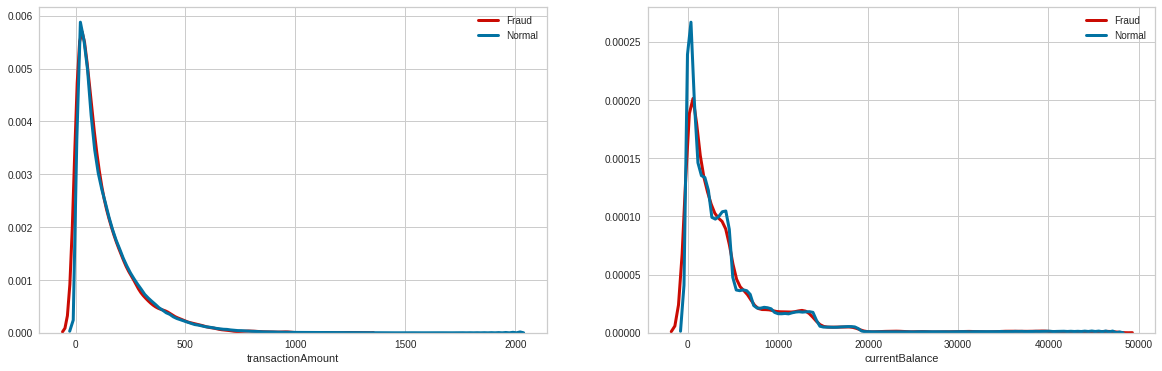

In [186]:
f, axes = plt.subplots(1,2, figsize=(20, 6), sharex=False)
sns.distplot(train_df[train_df['isFraud']==True]["transactionAmount"],hist=False,kde=True,color="r",label='Fraud',kde_kws={"color": "r", "lw": 3, "label": "KDE"},ax=axes[0])
sns.distplot(train_df[train_df['isFraud']==False]['transactionAmount'],hist=False,kde=True,color="b",label='Normal',kde_kws={"color": "b", "lw": 3, "label": "KDE"},ax=axes[0])
sns.distplot(train_df[train_df['isFraud']==True]["currentBalance"],hist=False,kde=True,color="r",label='Fraud',kde_kws={"color": "r", "lw": 3, "label": "KDE"},ax=axes[1])
sns.distplot(train_df[train_df['isFraud']==False]['currentBalance'],hist=False,kde=True,color="b",label='Normal',kde_kws={"color": "b", "lw": 3, "label": "KDE"},ax=axes[1])
plt.legend()
plt.show()

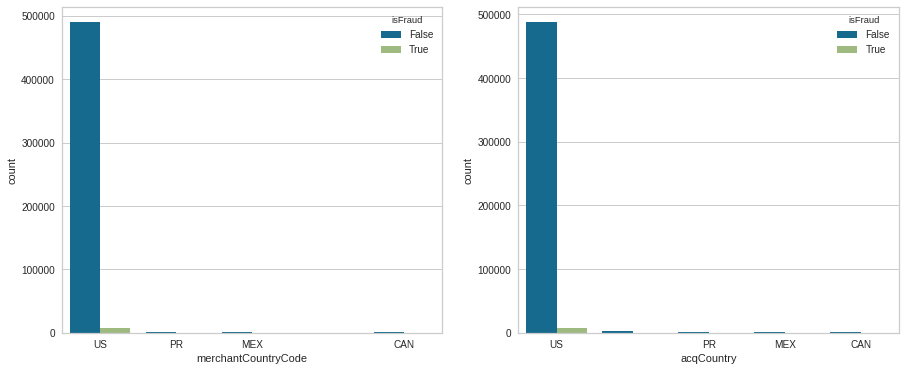

In [187]:
f, axes = plt.subplots(1,2, figsize=(15, 6), sharex=False)
sns.countplot('merchantCountryCode', data = train_df,hue="isFraud",ax=axes[0])
sns.countplot('acqCountry', data = train_df,hue="isFraud",ax=axes[1])
plt.show()

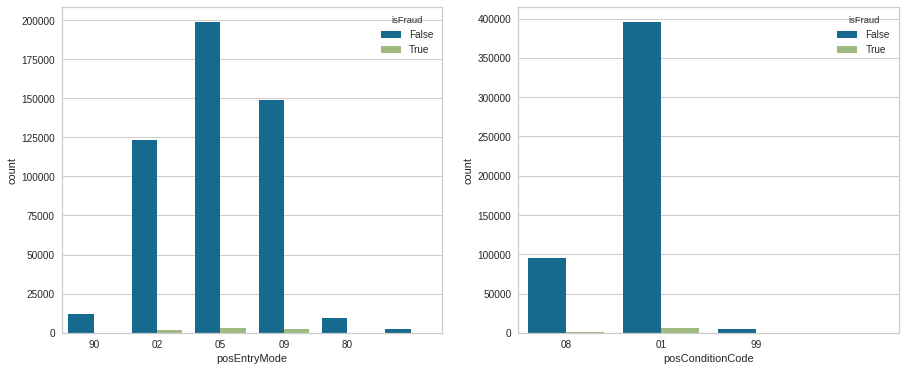

In [188]:
f, axes = plt.subplots(1,2, figsize=(15, 6), sharex=False)
sns.countplot('posEntryMode', data = train_df,hue="isFraud",ax=axes[0])
sns.countplot('posConditionCode', data = train_df,hue="isFraud",ax=axes[1])
plt.show()

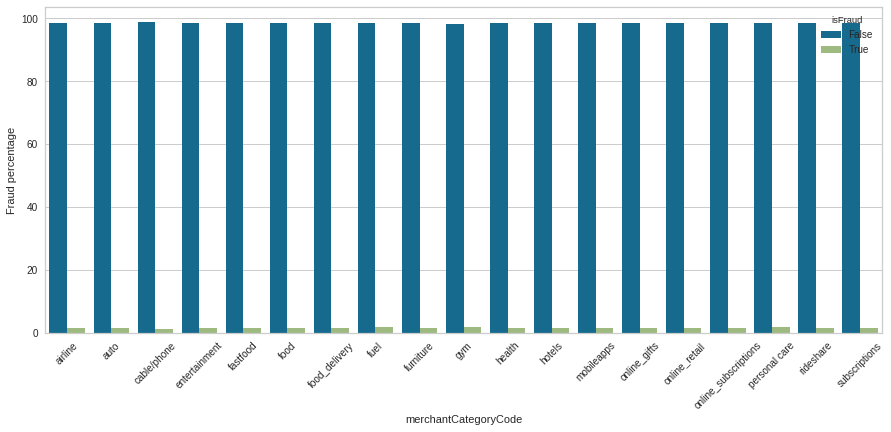

In [189]:
grp_by_merc_code = train_df.groupby(by=["merchantCategoryCode","isFraud"])["transaction_id"].count().reset_index()
grp_by_merc_code['Fraud percentage'] = grp_by_merc_code["transaction_id"]*100 / grp_by_merc_code.groupby("merchantCategoryCode")["transaction_id"].transform("sum")
a4_dims = (15, 6)
fig, ax = plt.subplots(figsize=a4_dims)
plt.xticks(rotation=45)
sns.barplot('merchantCategoryCode', 'Fraud percentage',hue = 'isFraud', data = grp_by_merc_code)
plt.show()

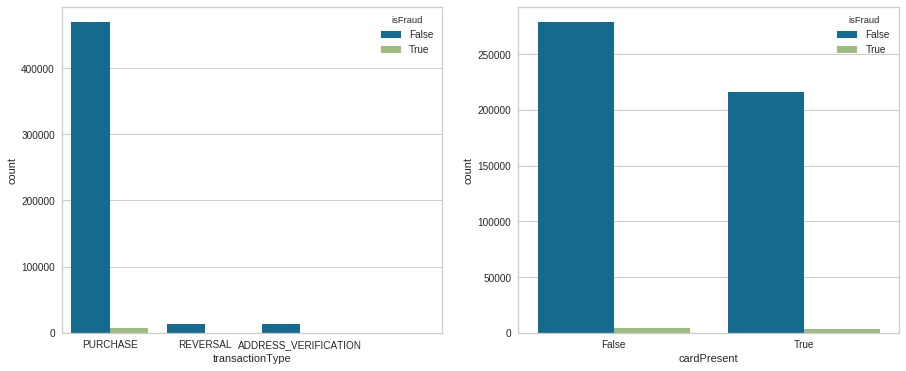

In [190]:
f, axes = plt.subplots(1,2, figsize=(15, 6), sharex=False)
sns.countplot('transactionType', data = train_df,hue="isFraud",ax=axes[0])
sns.countplot('cardPresent', data = train_df,hue="isFraud",ax=axes[1])
plt.show()

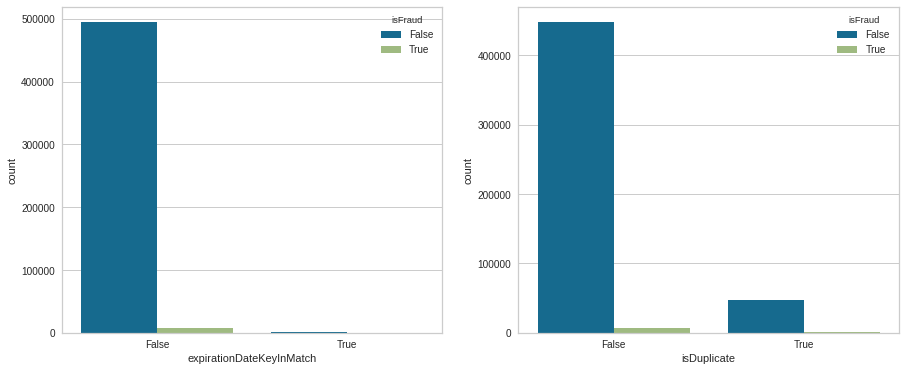

In [191]:
f, axes = plt.subplots(1,2, figsize=(15, 6), sharex=False)
sns.countplot('expirationDateKeyInMatch', data = train_df,hue="isFraud",ax=axes[0])
sns.countplot('isDuplicate', data = train_df,hue="isFraud",ax=axes[1])
plt.show()

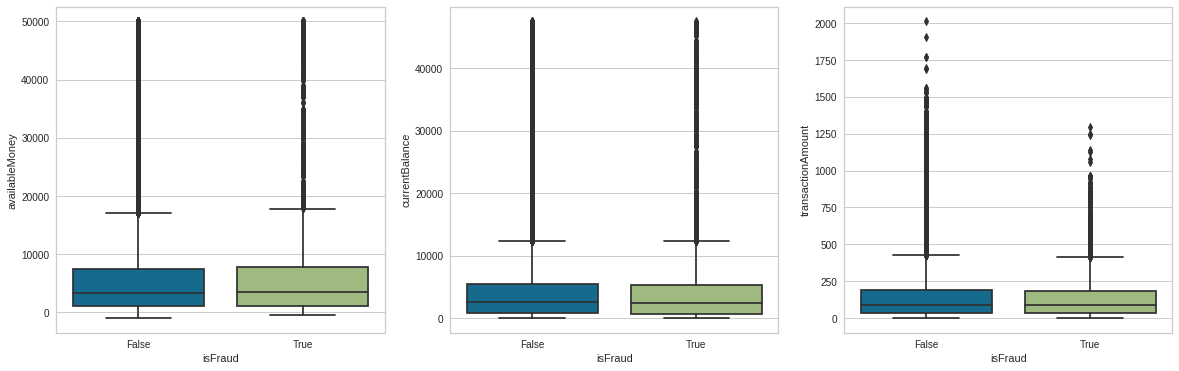

In [192]:
f, axes = plt.subplots(1,3, figsize=(20, 6), sharex=True)
ax = sns.boxplot(x="isFraud", y="availableMoney", data=train_df,ax =axes[0])
ax = sns.boxplot(x="isFraud", y="transactionAmount", data=train_df,ax =axes[2])
ax = sns.boxplot(x="isFraud", y="currentBalance", data=train_df,ax =axes[1])

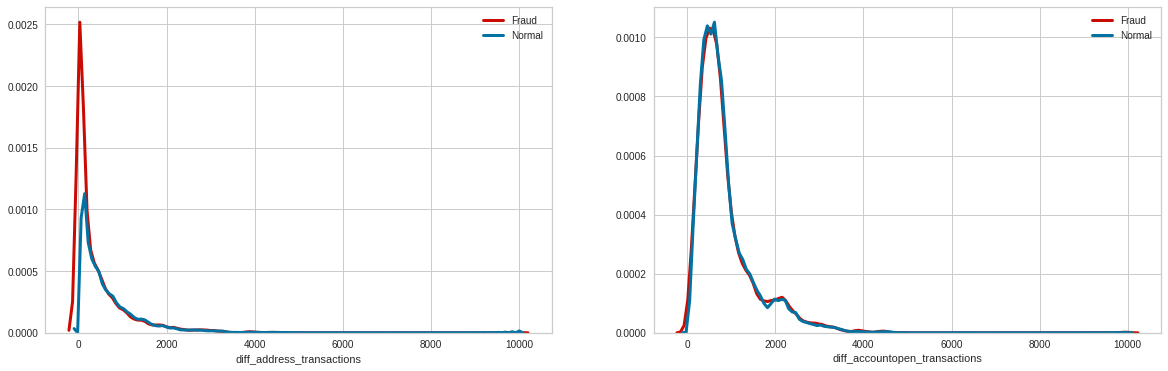

In [193]:
f, axes = plt.subplots(1,2, figsize=(20, 6), sharex=True)
sns.distplot(train_df[train_df['isFraud']==True]["diff_address_transactions"],hist=False,kde=True,color="r",label='Fraud',kde_kws={"color": "r", "lw": 3, "label": "KDE"},ax=axes[0])
sns.distplot(train_df[train_df['isFraud']==False]['diff_address_transactions'],hist=False,kde=True,color="b",label='Normal',kde_kws={"color": "b", "lw": 3, "label": "KDE"},ax=axes[0])
sns.distplot(train_df[train_df['isFraud']==True]["diff_accountopen_transactions"],hist=False,kde=True,color="r",label='Fraud',kde_kws={"color": "r", "lw": 3, "label": "KDE"},ax=axes[1])
sns.distplot(train_df[train_df['isFraud']==False]['diff_accountopen_transactions'],hist=False,kde=True,color="b",label='Normal',kde_kws={"color": "b", "lw": 3, "label": "KDE"},ax=axes[1])
plt.legend()
plt.show()

# Undersampling Training data

In [197]:
X_train_new = X_train.drop(["transaction_id"],axis=1)
X_test_new = X_test.drop(["transaction_id"],axis=1)
rus = RandomUnderSampler(random_state=5)
rus.fit(X_train, y_train)
X_resampled, y_resampled = rus.fit_resample(X_train_new, y_train)

print("Training Size After Random under sampling:",X_resampled.shape[0])

Training Size After Random under sampling: 19868


#Label Encoding for categorical Features and Scaler for continuous variables

In [0]:
numerical_features = X_train.select_dtypes(include=['float64']).columns
categorical_features = X_train.select_dtypes(include=['object','bool']).columns
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('woe', ce.OrdinalEncoder())])
preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, categorical_features),('num', numeric_transformer, numerical_features)])

In [0]:
preprocessor.fit(X_resampled)
X_resampled_trans =  preprocessor.transform(X_resampled)
X_test_trans = preprocessor.transform(X_test_new)

              precision    recall  f1-score   support

           0       0.99      0.31      0.47    154790
           1       0.02      0.89      0.04      2483

    accuracy                           0.32    157273
   macro avg       0.51      0.60      0.25    157273
weighted avg       0.98      0.32      0.46    157273



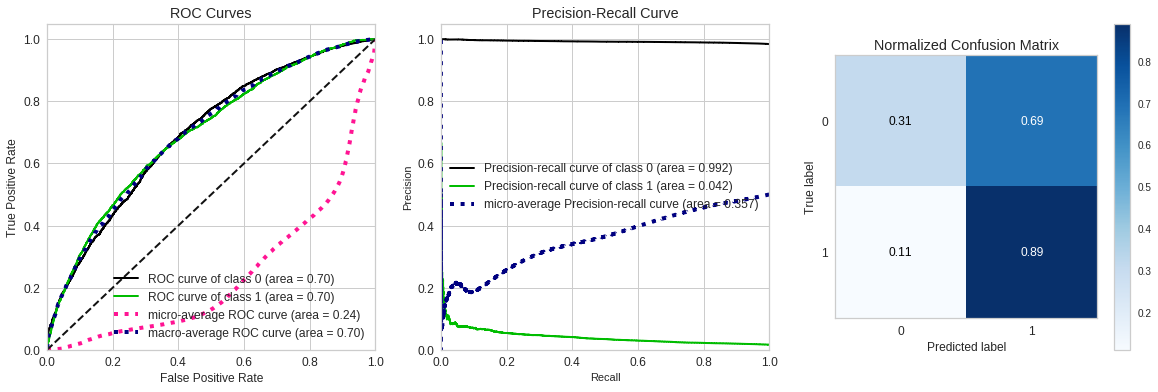

In [226]:
 lr = LogisticRegression(max_iter=1000,class_weight={0:0.35,1:0.65})
 model_lr = lr.fit(X_resampled_trans, y_resampled)
 y_score = model_lr.predict_proba(X_test_trans)
 y_pred = model_lr.predict(X_test_trans)
 print(classification_report(y_test, y_pred))
 f, axes = plt.subplots(1,3, figsize=(20, 6), sharex=False)
 skplt.metrics.plot_roc(y_test, y_score,ax=axes[0])
 skplt.metrics.plot_precision_recall(y_test, y_score,ax=axes[1])
 skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True,ax=axes[2])
 plt.show()
 

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.



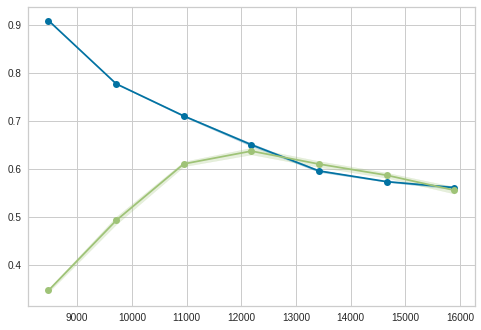

In [227]:
sizes = np.linspace(0.3, 1.0, 10)
visualizer = LearningCurve(model_lr,cv=5 ,scoring='f1_weighted',train_sizes=sizes, n_jobs=-1)

visualizer.fit(X_resampled_trans, y_resampled)        # Fit the data to the visualizer
plt.show() 

              precision    recall  f1-score   support

           0       0.99      0.72      0.83    154790
           1       0.04      0.72      0.08      2483

    accuracy                           0.72    157273
   macro avg       0.52      0.72      0.45    157273
weighted avg       0.98      0.72      0.82    157273



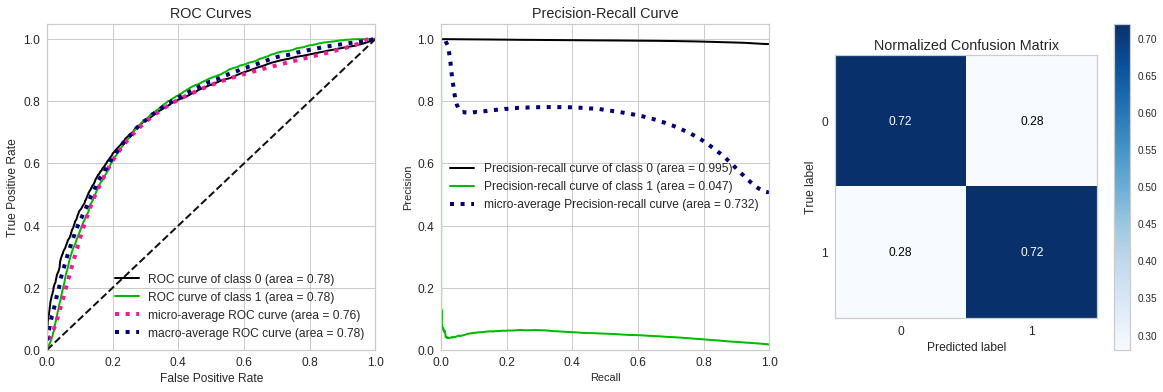

In [206]:
 rf = RandomForestClassifier(n_estimators=500)
 model_rf = rf.fit(X_resampled_trans, y_resampled)
 y_score = model_rf.predict_proba(X_test_trans)
 y_pred = model_rf.predict(X_test_trans)
 print(classification_report(y_test, y_pred))
 f, axes = plt.subplots(1,3, figsize=(20, 6), sharex=False)
 skplt.metrics.plot_roc(y_test, y_score,ax=axes[0])
 skplt.metrics.plot_precision_recall(y_test, y_score,ax=axes[1])
 skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True,ax=axes[2])
 plt.show()


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning:

From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



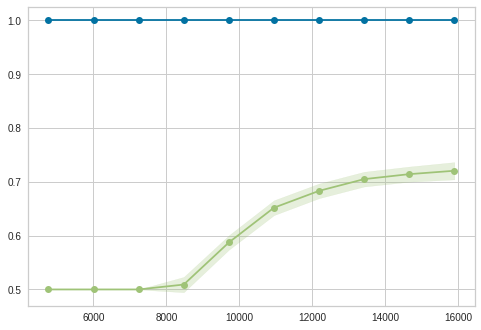

In [207]:
sizes = np.linspace(0.3, 1.0, 10)
visualizer = LearningCurve(rf,cv=5, scoring='f1_weighted',train_sizes=sizes, n_jobs=-1)

visualizer.fit(X_resampled_trans, y_resampled)        # Fit the data to the visualizer
plt.show() 

Feature Exploration: Let's check how data is distributed among normal and fraud transactions

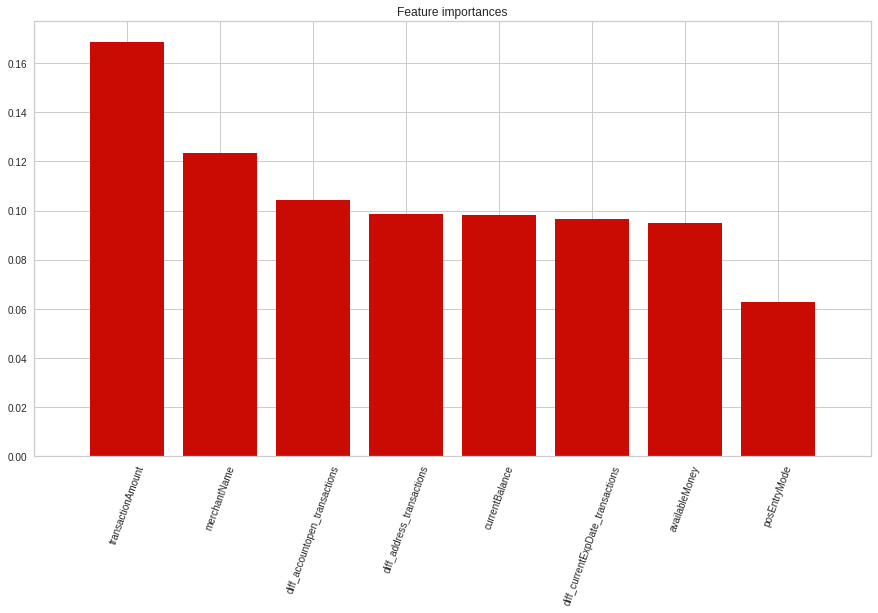

In [208]:
col_names = list(categorical_features.values)+list(numerical_features.values) #for feature importance
importances = rf.feature_importances_
std = np.std([rf.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][:8]
re_arranged_features = [ col_names[i] for i in indices][:8]
# Plot the feature importances of the forest
plt.figure(figsize=(15,8))
plt.title("Feature importances")
plt.bar(range(8), importances[indices],color="r", yerr=std[indices], align="center")
plt.xticks(range(8),labels=re_arranged_features,rotation=70)
plt.xlim([-1, 8])

plt.show()